# UTE - Precipitation Data
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@version**: v1.2
 - **@date**: 2022-08-06, 2022-08-01, 2022-07-30, 2022-07-26
 - **Url**:  
 - **Output**: ute_daily_2000_2020.nc

## Setup

In [1]:
dir_google_drive = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/Proyecto Colab/03 - DataLake/"
dir_data = './data/'
dir_data_source = dir_data+'/source/'
dir_var = './var/'
dir_download = dir_var+'/download/'
dir_output = dir_var+'/output/'
dir_log = dir_var+'/log/'


### Libraries

In [2]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.3 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149860 sha256=44757efa406759fa36d10a090706e60e59b1306fb568d4ed41869365ee7e7dba
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [3]:
!pip install geopandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.8 MB/s 
     |████████████████████████████████| 6.3 MB 43.3 MB/s 
     |████████████████████████████████| 16.7 MB 344 kB/s 


In [4]:
# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
import os 
# import shutil
import glob

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [5]:
def get_geometry_uruguay():
  df_world_shapes = gpd.read_file(dir_data+"/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp")
  df_uruguay_shapes = df_world_shapes[ df_world_shapes['ISO2'] == 'UY']
  # df_uruguay_shapes
  polygon_uruguay = df_uruguay_shapes['geometry']
  return polygon_uruguay
  # polygon_uruguay = geometry[210]
  # return gpd.GeoSeries(polygon_uruguay)

### Init

In [6]:
!rm -rf "$dir_data"

!mkdir -p "$dir_data"
!mkdir -p "$dir_data_source"
!mkdir -p "$dir_download"
!mkdir -p "$dir_output"
!mkdir -p "$dir_log"

!mkdir -p "$dir_data"/TM_WORLD_BORDERS
!wget  -O "$dir_download"/TM_WORLD_BORDERS-0.3.zip  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip 
!unzip -o "$dir_download"/TM_WORLD_BORDERS-0.3.zip -d "$dir_data"/TM_WORLD_BORDERS 


--2022-08-06 07:18:59--  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
Resolving thematicmapping.org (thematicmapping.org)... 67.20.120.230
Connecting to thematicmapping.org (thematicmapping.org)|67.20.120.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3464707 (3.3M) [application/zip]
Saving to: ‘./var//download//TM_WORLD_BORDERS-0.3.zip’

./var//download//TM 100%[===================>]   3.30M  7.81MB/s    in 0.4s    

2022-08-06 07:19:00 (7.81 MB/s) - ‘./var//download//TM_WORLD_BORDERS-0.3.zip’ saved [3464707/3464707]

Archive:  ./var//download//TM_WORLD_BORDERS-0.3.zip
  inflating: ./data//TM_WORLD_BORDERS/Readme.txt  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.dbf  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.prj  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shx  


## Download Data

In [7]:
filename = dir_download+"/ute_raw_data_2000_2020.zip"
!gdown -O $filename "1m_wX4vX2JDC_x9ygezUZhxWeSeISfGOS"

!unzip -q -o "$filename"  -d "$dir_data_source" 
!mv "$dir_data_source"/data/* "$dir_data_source"  

Downloading...
From: https://drive.google.com/uc?id=1m_wX4vX2JDC_x9ygezUZhxWeSeISfGOS
To: /content/var/download/ute_raw_data_2000_2020.zip
100% 6.94M/6.94M [00:00<00:00, 115MB/s]


### Pre Processing

In [8]:
# https://apps.ute.com.uy/SgePublico/MapaEstacionesHid.aspx
filename_estaciones_data = dir_data+"/ute_estaciones_data.csv"
!gdown -O $filename_estaciones_data "1j7URTkXS7puosntwHQmbOotjVfj4QOdb"

Downloading...
From: https://drive.google.com/uc?id=1j7URTkXS7puosntwHQmbOotjVfj4QOdb
To: /content/data/ute_estaciones_data.csv
100% 10.9k/10.9k [00:00<00:00, 18.2MB/s]


In [9]:
df_estaciones = pd.read_csv(filename_estaciones_data)
df_estaciones = df_estaciones[  df_estaciones['type'].str.find('modificado') < 0]
df_estaciones[:3]                            

,id,name,lat,lon,type
0,1496,Aceguá,-31.874111,-54.161000,PluvConv
1,1734,Achar,-32.404028,-56.180722,PluvConv
2,1521,Aldea San Joaquín,-31.959417,-55.810861,PluvConv


### Merge Estaciones and Precipitations

In [10]:
%%bash
rm -rf /content/data/temp/
mkdir -p /content/data/temp/

cd /content/data/source/
for f in *.txt; do iconv -f ISO-8859-1 -t utf-8 "$f" > /content/data/temp/"$f"; done


In [11]:
# ---------------------------------------------
# Hack: Join all file in one
# ---------------------------------------------
ute_all_csv = dir_data+"/ute_all_csv.csv"

# !echo "date;code;cuenca;subcuenca;paso;estacion;precipitacion;obs" > "$dir_download"/header.csv
!echo "" > "$dir_download"/header.csv
!cat "$dir_download"/header.csv <(tail -q -n +3 /content/data/temp/*.txt) > "$ute_all_csv".tmp
!grep "\S"  "$ute_all_csv".tmp > "$ute_all_csv".2.tmp

!head -10 "$ute_all_csv".2.tmp
!cat "$ute_all_csv".2.tmp | wc -l 


!sort -u "$ute_all_csv".2.tmp > "$ute_all_csv"
!cat "$ute_all_csv" | wc -l 

01/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
02/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
03/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
04/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
05/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
06/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
07/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
08/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
09/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
10/01/2000; 700; Central Baygorria; Directa Baygorria; Local Baygorria; El Monumento ;  ; 
1386768
tcmalloc: large alloc 8207712256 bytes == 0x55f1ee7c0000 @  0x7fc336ce31e7 0x55f1e

In [12]:
# 1386769 - 1032165 = 1032165

In [13]:

encoding='utf8'

import datetime 
dateparse = lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') # %Y-%m-%d %H:%M:%S  

names=['date','code','cuenca','subcuenca','paso','estacion','precipitacion','obs']
df_gauge = pd.read_csv(ute_all_csv,names=names,
                        index_col=False, sep=';', encoding = encoding, 
                        parse_dates=["date"],date_parser=dateparse)
df_gauge.loc[df_gauge['precipitacion'] == '', 'precipitacion'] = -999
df_gauge.loc[df_gauge['precipitacion'] == ' ', 'precipitacion'] = -999
df_gauge.loc[df_gauge['precipitacion'] == '  ', 'precipitacion'] = -999

df_gauge['precipitacion'] = df_gauge['precipitacion'].astype(float)
df_gauge

,date,code,cuenca,subcuenca,paso,estacion,precipitacion,obs
0,2000-01-01,700,Bajo Río Negro,Desemb. en Río Uruguay,Villa Soriano,Cañitas,0.0,
1,2000-01-01,700,Bajo Río Negro,Desemb. en Río Uruguay,Villa Soriano,Villa Soriano,0.0,
2,2000-01-01,700,Bajo Río Negro,Mercedes,Mercedes,Arroyo Corto,0.0,
3,2000-01-01,700,Bajo Río Negro,Mercedes,Mercedes,Egaña,0.0,
4,2000-01-01,700,Bajo Río Negro,Mercedes,Mercedes,Ejido,0.0,
...,...,...,...,...,...,...,...,...
1032159,2020-12-31,700,Central Rincón del Bonete,Tacuarembó,Novillos,Cerro Travieso,-999.0,
1032160,2020-12-31,700,Central Rincón del Bonete,Tacuarembó,Novillos,E.M. Tacuarembó,-999.0,
1032161,2020-12-31,700,Central Rincón del Bonete,Tacuarembó,Novillos,Luján,0.0,
1032162,2020-12-31,700,Central Rincón del Bonete,Tacuarembó,Novillos,Paso de las Carretas,6.0,


In [14]:
# ------------------------------------------------------------------------------
# See hack above
# ------------------------------------------------------------------------------

# df_gauge = None

# encoding='utf8'

# import datetime 
# dateparse = lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') # %Y-%m-%d %H:%M:%S  


# files = glob.glob(dir_data+'/temp/*')  
# for f in files:
#   print("Processing: ", f)
#   names=['date','code','cuenca','subcuenca','paso','estacion','precipitacion','obs']
#   _df_gauge = pd.read_csv(f,index_col=False, skiprows=2,names=names, sep=';', encoding = encoding, 
#                           parse_dates=["date"],date_parser=dateparse)
  
#   _df_gauge.loc[_df_gauge['precipitacion'] == '', 'precipitacion'] = -999
#   _df_gauge.loc[_df_gauge['precipitacion'] == ' ', 'precipitacion'] = -999
#   _df_gauge.loc[_df_gauge['precipitacion'] == '  ', 'precipitacion'] = -999

#   _df_gauge['precipitacion'] = _df_gauge['precipitacion'].astype(float)

#   if df_gauge is None:
#     df_gauge = _df_gauge
#   else:
#     df_gauge = df_gauge.append(_df_gauge) 

# df_gauge


In [15]:
# ------------------------------------------------------------------------------
# Machine Learning : sinonimos para aprox de nombre de estaciones
# ------------------------------------------------------------------------------

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

df_estaciones_name = df_estaciones['name'].unique()
estaciones = df_gauge['estacion'].unique()

df_estaciones_sinonimos = []
for e in estaciones:
  near = process.extractOne(e, df_estaciones_name)
  df_estaciones_sinonimos.append([e,near[0],near[1]])
df_estaciones_sinonimos = pd.DataFrame(df_estaciones_sinonimos, columns=['estacion_raw', 'name','distance'])
df_estaciones_sinonimos[:3]

,estacion_raw,name,distance
0,Cañitas,Cañitas,100
1,Villa Soriano,Villa Soriano,100
2,Arroyo Corto,Arroyo Corto,100


In [16]:
# add lat lon
df_estaciones_sinonimos = pd.merge( df_estaciones_sinonimos, 
                                    df_estaciones[['name','lat','lon']], 
                                    left_on="name", right_on="name", 
                                    how="left", 
                                    sort=False)
df_estaciones_sinonimos


,estacion_raw,name,distance,lat,lon
0,Cañitas,Cañitas,100,-33.161028,-58.237000
1,Villa Soriano,Villa Soriano,100,-33.390889,-58.318111
2,Arroyo Corto,Arroyo Corto,100,-33.239917,-57.784139
3,Egaña,Egaña,100,-33.602639,-57.631583
4,Ejido,Ejido,100,-33.278639,-57.974167
...,...,...,...,...,...
135,Barra de Porongos,Barra de Porongos,100,-33.250556,-56.815556
136,Cuñapirú,Cuñapirú,100,-31.529722,-55.584167
137,Feliciano,Feliciano,100,-33.186444,-56.808694
138,San Jorge,San Jorge,100,-32.842583,-55.897028


In [17]:
df_gauge = pd.merge(  df_gauge, 
                      df_estaciones_sinonimos[['estacion_raw','lat','lon']], 
                      left_on="estacion", right_on="estacion_raw", 
                      how="left", 
                      sort=False)
df_gauge[:3]

,date,code,cuenca,subcuenca,paso,estacion,precipitacion,obs,estacion_raw,lat,lon
0,2000-01-01,700,Bajo Río Negro,Desemb. en Río Uruguay,Villa Soriano,Cañitas,0.0,,Cañitas,-33.161028,-58.237000
1,2000-01-01,700,Bajo Río Negro,Desemb. en Río Uruguay,Villa Soriano,Villa Soriano,0.0,,Villa Soriano,-33.390889,-58.318111
2,2000-01-01,700,Bajo Río Negro,Mercedes,Mercedes,Arroyo Corto,0.0,,Arroyo Corto,-33.239917,-57.784139


In [18]:
df_gauge = df_gauge.sort_values(['date','lat','lon'])
df_gauge = df_gauge.set_index(['date', 'lat', 'lon'])
df_gauge

code                      cuenca  \
date       lat        lon                                            
2000-01-01 -33.878972 -56.757194   700        Central Constitución   
           -33.872417 -57.369972   700        Central Constitución   
           -33.862556 -55.549194   700        Central Constitución   
           -33.829583 -57.016167   700        Central Constitución   
           -33.828750 -57.788056   700        Central Constitución   
...                                ...                         ...   
2020-12-31 -31.394000 -55.394444   700   Central Rincón del Bonete   
           -31.201083 -55.362194   700   Central Rincón del Bonete   
           -31.190778 -55.764944   700   Central Rincón del Bonete   
           -31.095389 -55.687000   700   Central Rincón del Bonete   
           -30.896472 -55.542417   700   Central Rincón del Bonete   

                                               subcuenca             paso  \
date       lat        lon                                                   
2000-01-01 -33.878972 -56.757194                  Río Yí    Paso del Bote   
           -33.872417 -57.369972   Arroyo Grande del Sur             Lugo   
           -33.862556 -55.549194                  Río Yí   Polanco del Yí   
           -33.829583 -57.016167   Arroyo Grande del Sur             Lugo   
           -33.828750 -57.788056   Arroyo Grande del Sur             Lugo   
...                                                  ...              ...   
2020-12-31 -31.394000 -55.394444              Tacuarembó         Borracho   
           -31.201083 -55.362194              Tacuarembó         Cuñapirú   
           -31.190778 -55.764944              Tacuarembó      Manuel Díaz   
           -31.095389 -55.687000              Tacuarembó         Cuñapirú   
           -30.896472 -55.542417              Tacuarembó         Cuñapirú   

                                           estacion  precipitacion obs  \
date       lat        lon                                                
2000-01-01 -33.878972 -56.757194             Pintos            0.0       
           -33.872417 -57.369972            Cardona            0.0       
           -33.862556 -55.549194     Cerro Colorado            0.0       
           -33.829583 -57.016167   Puntas del Sauce            0.0       
           -33.828750 -57.788056          Corralito         -999.0       
...                                             ...            ...  ..   
2020-12-31 -31.394000 -55.394444          La Calera         -999.0       
           -31.201083 -55.362194       Paso Ataques           26.0       
           -31.190778 -55.764944         Tranqueras           35.0       
           -31.095389 -55.687000       Est. Ataques           23.0       
           -30.896472 -55.542417        E.M. Rivera           10.0       

                                       estacion_raw  
date       lat        lon                            
2000-01-01 -33.878972 -56.757194             Pintos  
           -33.872417 -57.369972            Cardona  
           -33.862556 -55.549194     Cerro Colorado  
           -33.829583 -57.016167   Puntas del Sauce  
           -33.828750 -57.788056          Corralito  
...                                             ...  
2020-12-31 -31.394000 -55.394444          La Calera  
           -31.201083 -55.362194       Paso Ataques  
           -31.190778 -55.764944         Tranqueras  
           -31.095389 -55.687000       Est. Ataques  
           -30.896472 -55.542417        E.M. Rivera  

[1032164 rows x 8 columns]

In [19]:
# Check duplicated
df_gauge[df_gauge.index.duplicated()]

,,,code,cuenca,subcuenca,paso,estacion,precipitacion,obs,estacion_raw
date,lat,lon,,,,,,,,


In [20]:
# Importante para poder eliminar duplicados hay que realizar un reset de los indices
df_gauge = df_gauge.reset_index()
df_gauge.drop_duplicates(subset=['date','lat','lon'], inplace=True, keep='first') 
df_gauge

,date,lat,lon,code,cuenca,subcuenca,paso,estacion,precipitacion,obs,estacion_raw
0,2000-01-01,-33.878972,-56.757194,700,Central Constitución,Río Yí,Paso del Bote,Pintos,0.0,,Pintos
1,2000-01-01,-33.872417,-57.369972,700,Central Constitución,Arroyo Grande del Sur,Lugo,Cardona,0.0,,Cardona
2,2000-01-01,-33.862556,-55.549194,700,Central Constitución,Río Yí,Polanco del Yí,Cerro Colorado,0.0,,Cerro Colorado
3,2000-01-01,-33.829583,-57.016167,700,Central Constitución,Arroyo Grande del Sur,Lugo,Puntas del Sauce,0.0,,Puntas del Sauce
4,2000-01-01,-33.828750,-57.788056,700,Central Constitución,Arroyo Grande del Sur,Lugo,Corralito,-999.0,,Corralito
...,...,...,...,...,...,...,...,...,...,...,...
1032159,2020-12-31,-31.394000,-55.394444,700,Central Rincón del Bonete,Tacuarembó,Borracho,La Calera,-999.0,,La Calera
1032160,2020-12-31,-31.201083,-55.362194,700,Central Rincón del Bonete,Tacuarembó,Cuñapirú,Paso Ataques,26.0,,Paso Ataques
1032161,2020-12-31,-31.190778,-55.764944,700,Central Rincón del Bonete,Tacuarembó,Manuel Díaz,Tranqueras,35.0,,Tranqueras
1032162,2020-12-31,-31.095389,-55.687000,700,Central Rincón del Bonete,Tacuarembó,Cuñapirú,Est. Ataques,23.0,,Est. Ataques


In [21]:
# df_gauge.to_csv('df_gauge_thirt.csv')

In [22]:
# restauramos los indices
df_gauge.set_index(['date','lat','lon'], inplace=True)
df_gauge

code                      cuenca  \
date       lat        lon                                            
2000-01-01 -33.878972 -56.757194   700        Central Constitución   
           -33.872417 -57.369972   700        Central Constitución   
           -33.862556 -55.549194   700        Central Constitución   
           -33.829583 -57.016167   700        Central Constitución   
           -33.828750 -57.788056   700        Central Constitución   
...                                ...                         ...   
2020-12-31 -31.394000 -55.394444   700   Central Rincón del Bonete   
           -31.201083 -55.362194   700   Central Rincón del Bonete   
           -31.190778 -55.764944   700   Central Rincón del Bonete   
           -31.095389 -55.687000   700   Central Rincón del Bonete   
           -30.896472 -55.542417   700   Central Rincón del Bonete   

                                               subcuenca             paso  \
date       lat        lon                                                   
2000-01-01 -33.878972 -56.757194                  Río Yí    Paso del Bote   
           -33.872417 -57.369972   Arroyo Grande del Sur             Lugo   
           -33.862556 -55.549194                  Río Yí   Polanco del Yí   
           -33.829583 -57.016167   Arroyo Grande del Sur             Lugo   
           -33.828750 -57.788056   Arroyo Grande del Sur             Lugo   
...                                                  ...              ...   
2020-12-31 -31.394000 -55.394444              Tacuarembó         Borracho   
           -31.201083 -55.362194              Tacuarembó         Cuñapirú   
           -31.190778 -55.764944              Tacuarembó      Manuel Díaz   
           -31.095389 -55.687000              Tacuarembó         Cuñapirú   
           -30.896472 -55.542417              Tacuarembó         Cuñapirú   

                                           estacion  precipitacion obs  \
date       lat        lon                                                
2000-01-01 -33.878972 -56.757194             Pintos            0.0       
           -33.872417 -57.369972            Cardona            0.0       
           -33.862556 -55.549194     Cerro Colorado            0.0       
           -33.829583 -57.016167   Puntas del Sauce            0.0       
           -33.828750 -57.788056          Corralito         -999.0       
...                                             ...            ...  ..   
2020-12-31 -31.394000 -55.394444          La Calera         -999.0       
           -31.201083 -55.362194       Paso Ataques           26.0       
           -31.190778 -55.764944         Tranqueras           35.0       
           -31.095389 -55.687000       Est. Ataques           23.0       
           -30.896472 -55.542417        E.M. Rivera           10.0       

                                       estacion_raw  
date       lat        lon                            
2000-01-01 -33.878972 -56.757194             Pintos  
           -33.872417 -57.369972            Cardona  
           -33.862556 -55.549194     Cerro Colorado  
           -33.829583 -57.016167   Puntas del Sauce  
           -33.828750 -57.788056          Corralito  
...                                             ...  
2020-12-31 -31.394000 -55.394444          La Calera  
           -31.201083 -55.362194       Paso Ataques  
           -31.190778 -55.764944         Tranqueras  
           -31.095389 -55.687000       Est. Ataques  
           -30.896472 -55.542417        E.M. Rivera  

[1032164 rows x 8 columns]

In [23]:
df_gauge.dtypes

code               int64
cuenca            object
subcuenca         object
paso              object
estacion          object
precipitacion    float64
obs               object
estacion_raw      object
dtype: object

### Export Raw Inumet

In [24]:
file_pkl = dir_output+'ute_raw_2000_2020.pkl'
df_gauge.to_pickle(file_pkl,compression='gzip')
!cp "$file_pkl" "$dir_google_drive" 

## Config

In [25]:
# # Performance 
# file_pkl = dir_google_drive+'ute_raw_2000_2020.pkl'
# df_gauge = pd.read_pickle(file_pkl,compression='gzip')
# # df_gauge

In [26]:
var_lat = 'lat'
var_lon = 'lon'
var_time = 'date'
var_precipitation = 'precipitacion'

var_null_values = -598

var_null_values_from_source = -999.0

## Process Data

In [27]:
ds_xr_multi = df_gauge[['precipitacion']].to_xarray() # important
ds_xr_multi

<xarray.Dataset>
Dimensions:        (date: 7671, lat: 139, lon: 140)
Coordinates:
  * date           (date) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float64 -33.88 -33.87 -33.86 ... -31.19 -31.1 -30.9
  * lon            (lon) float64 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitacion  (date, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [28]:
ds_xr_multi[var_precipitation].data

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [29]:
# ds_xr_multi.isel(date=365)['precipitacion'].plot()

### Standarize

In [30]:
names = {var_time:'time', var_precipitation:'precipitation', var_lat:'lat', var_lon:'lon'}
ds_xr_multi = ds_xr_multi.rename(names)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float64 -33.88 -33.87 -33.86 ... -31.19 -31.1 -30.9
  * lon            (lon) float64 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [31]:
ds_xr_multi = ds_xr_multi[['precipitation']]
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float64 -33.88 -33.87 -33.86 ... -31.19 -31.1 -30.9
  * lon            (lon) float64 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [32]:
ds_xr_multi['precipitation'] = ds_xr_multi['precipitation'].astype(np.float32)
ds_xr_multi['lat'] = ds_xr_multi['lat'].astype(np.float32)
ds_xr_multi['lon'] = ds_xr_multi['lon'].astype(np.float32)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float32 -33.88 -33.87 -33.86 ... -31.19 -31.1 -30.9
  * lon            (lon) float32 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

### Filtre

In [33]:
# replace all missing values with -999
mask = (ds_xr_multi['precipitation'] == var_null_values_from_source)
ds_xr_multi['precipitation'] = xr.where(mask, var_null_values, ds_xr_multi['precipitation'])
ds_xr_multi_query = ds_xr_multi

In [34]:
# Uruguay box
lat_max = -30; lat_min = -35
lon_max = -53; lon_min = -59

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] < lat_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] > lat_min, drop=True)

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] < lon_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] > lon_min, drop=True)

In [35]:
ds_xr_multi_query_done = ds_xr_multi_query.compute()
ds_xr_multi_query_done

<xarray.Dataset>
Dimensions:        (time: 7671, lat: 139, lon: 140)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat            (lat) float32 -33.88 -33.87 -33.86 ... -31.19 -31.1 -30.9
  * lon            (lon) float32 -58.32 -58.24 -58.07 ... -54.05 -53.95 -53.79
Data variables:
    precipitation  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

## Export

In [36]:
encoding = {'precipitation': {
                  #'_FillValue': var_null_values,      NOT SUPPORTED by xArray
                  #'missing_value': var_null_values,   NOT SUPPORTED by xArray
                  # 'chunksizes': (1, 8, 10),
                  'complevel': 9,
                  'zlib': True}
            }            
file_nc = dir_output+'/ute_daily_2000_2020.nc'
ds_xr_multi_query_done.to_netcdf(file_nc,mode="w", encoding=encoding)

In [40]:
# Export to drive (optional)
!cp "$file_nc" "$dir_google_drive" 

## Plot

In [ ]:
# !apt install netcdf-bin
# file_nc = dir_google_drive+'/ute_daily_2000_2020.nc' 
# !ncdump -h "$file_nc"

In [43]:
file_nc = dir_google_drive+'/ute_daily_2000_2020.nc' 

df_xr_raw = xr.open_dataset(file_nc) # !Important for Null Values
# !Important
mask = df_xr_raw.precipitation > 0
df_xr = df_xr_raw.where( mask )

# No Funciona con xarray
# df_xr = xr.open_dataset(file_nc, mask_and_scale=True) # !Important for Null Values -598
# df_xr

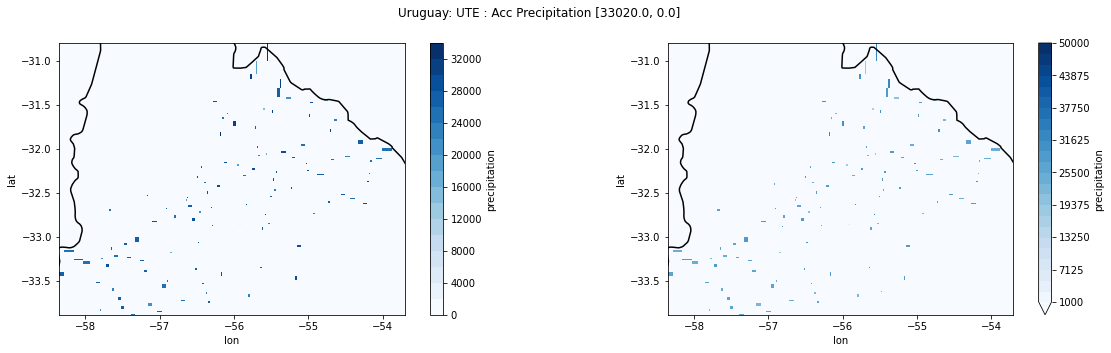

In [44]:
# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))  

df_xr_acc = df_xr.sum(dim="time")['precipitation']


df_xr_acc.plot(ax=axs[0], x="lon", y="lat", cmap="Blues", levels=20)
geodf_shape.boundary.plot(ax=axs[0], color="black")

df_xr_acc.plot(ax=axs[1], x="lon", y="lat", cmap="Blues", levels=np.linspace(1000, 50000, 25))
geodf_shape.boundary.plot(ax=axs[1], color="black")

prec_max = np.round(float(df_xr_acc.max().data), 2)
prec_min = np.round(float(df_xr_acc.min().data), 2)
fig.suptitle(f'Uruguay: UTE : Acc Precipitation [{prec_max}, {prec_min}]', fontsize=12)
plt.show()